In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import joblib
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, Sampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score
import optuna
import itertools
import math

In [3]:
# Fix randomness for reproducibility, but may still have slight variation

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Get a unique seed for each worker based on torch's initial seed
    worker_seed = (RANDOM_SEED + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
train_df = joblib.load(r'..\assets\combined\train_ready.pkl')
test_df = joblib.load(r'..\assets\combined\test_ready.pkl')

print(train_df.shape, test_df.shape)

(2595694, 130) (694120, 130)


In [5]:
train_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595694 entries, 0 to 2595693
Data columns (total 130 columns):
 #    Column                                             Non-Null Count    Dtype  
---   ------                                             --------------    -----  
 0    user_id                                            2595694 non-null  object 
 1    app_id                                             2595694 non-null  int64  
 2    relevance_score                                    2595694 non-null  float64
 3    user_country_code                                  2595694 non-null  object 
 4    user_has_coordinates                               2595694 non-null  bool   
 5    user_latitude                                      2595694 non-null  float64
 6    user_longitude                                     2595694 non-null  float64
 7    user_account_age_months                            2595694 non-null  float64
 8    game_name                                         

## Preprocessing categorical columns before passing them to embedding layer

In [6]:
# Note that categorical columns with less than 20 unique values are already one-hot encoded
# Here will only handle the rest

single_cat_cols = []
multi_cat_cols = []

for col in train_df.select_dtypes(include=['object']).columns:
    if not col in ['user_id', 'user_emb', 'game_emb']:
        if isinstance(train_df[col].iloc[0], list):
            multi_cat_cols.append(col)
        else:
            single_cat_cols.append(col)

num_cols = [col for col in train_df.select_dtypes(include=['number']).columns if not col in ['app_id', 'relevance_score']]
# bool_cols also includes one-hot columns
bool_cols = [col for col in train_df.select_dtypes(include=['bool']).columns]
cf_emb_cols = ['user_emb', 'game_emb']

print(single_cat_cols, '\n', multi_cat_cols, '\n', num_cols, '\n', bool_cols)

['user_country_code'] 
 ['game_tags', 'game_available_platform', 'game_developer', 'game_publisher'] 
 ['user_latitude', 'user_longitude', 'user_account_age_months', 'game_RAWG_weighted_avg_rating', 'game_RAWG_ratings_count', 'game_RAWG_reviews_with_text_count', 'game_RAWG_bookmark_count', 'game_metacritic_rating', 'game_RAWG_system_suggest_count', 'game_RAWG_reviews_count', 'game_released_month', 'game_released_day', 'game_RAWG_rating_5_percent', 'game_RAWG_rating_4_percent', 'game_RAWG_rating_3_percent', 'game_RAWG_rating_1_percent', 'game_RAWG_bookmark_type_yet_count', 'game_RAWG_bookmark_type_owned_count', 'game_RAWG_bookmark_type_beaten_count', 'game_RAWG_bookmark_type_toplay_count', 'game_RAWG_bookmark_type_dropped_count', 'game_RAWG_bookmark_type_playing_count', 'game_positive_review_count', 'game_negative_review_count', 'game_avg_playtime_forever', 'game_median_playtime_forever', 'game_current_price', 'game_initial_price', 'game_concurrent_user', 'game_estimate_owners_lower', '

### Label encode categorical columns in train set

In [7]:
for col in single_cat_cols:
    print(f"{col}: {train_df[col].nunique()}")
for col in multi_cat_cols:
    print(f"{col}: {train_df[col].explode().nunique()}")

user_country_code: 222
game_tags: 2460
game_available_platform: 47
game_developer: 15183
game_publisher: 10723


Since game_tags, game_developer, and game_publisher have extremely high-cardinality, we first group infrequent categories into "Other".

In [8]:
coverage_threshold = 0.80
cat_to_other_mapper = {}  # Save for mapping cat to other in test set

for col in ['game_tags', 'game_developer', 'game_publisher']:
    all_categories = list(itertools.chain.from_iterable(train_df[col]))  # Flatten

    freq_counts = pd.Series(all_categories).value_counts()
    cumulative_fraction = freq_counts.cumsum() / freq_counts.sum()
    
    # 80% coverage cutoff
    cutoff_index = np.searchsorted(cumulative_fraction, coverage_threshold)
    
    # Keep only about 80%
    top_cats = set(freq_counts.index[:cutoff_index])

    # Save mapper for test set
    mapper = {cat: (cat if cat in top_cats else "Other") for cat in freq_counts.index}
    cat_to_other_mapper[col] = mapper

    def map_cat_list_to_top(cat_list):
        return list({cat if cat in top_cats else "Other" for cat in cat_list})  # Only keep single "Other" label

    train_df[col] = train_df[col].apply(map_cat_list_to_top)


In [9]:
for col in single_cat_cols:
    print(f"{col}: {train_df[col].nunique()}")
for col in multi_cat_cols:
    print(f"{col}: {train_df[col].explode().nunique()}")

user_country_code: 222
game_tags: 111
game_available_platform: 47
game_developer: 3278
game_publisher: 1503


In [10]:
# sklearn label encoder is too damn slow, use dict instead

single_cat_label_encoders = {}
multi_cat_label_encoders = {}
max_seq_len_per_column = {}

new_columns_single = {}
new_columns_multi_padded = {}

# Label Encode Single Categorical Columns
for col in single_cat_cols:
    all_categories = train_df[col].unique().tolist()

    mapping = {cat: i for i, cat in enumerate(all_categories)}
    single_cat_label_encoders[col] = mapping  # Store mapper for later use on test set

    new_columns_single[col + '_encoded'] = train_df[col].map(mapping)

# Label Encode and Pad Multi-Categorical
for col in multi_cat_cols:
    all_categories = set(itertools.chain.from_iterable(train_df[col]))
    
    mapping = {cat: i + 1 for i, cat in enumerate(all_categories)}
    multi_cat_label_encoders[col] = mapping  # Store mapper for later use on test set
    
    # Label encode each category
    encoded_lists = [[mapping[item] for item in row] for row in train_df[col]]
    
    # Compute the max sequence length for the current column
    max_seq_len_per_column[col] = max(len(seq) for seq in encoded_lists)
    
    # Pad sequences with 0 (padding index)
    PADDING_VALUE = 0
    padded_sequences = pad_sequence(
        [torch.tensor(seq, dtype=torch.int64) for seq in encoded_lists],
        batch_first=True, padding_value=PADDING_VALUE
    )

    max_index = padded_sequences.numpy().max()
    print(f"Column {col}, max index: {max_index}, pad size: {padded_sequences.shape[1]}")
    
    new_columns_multi_padded[col + '_encoded_padded'] = padded_sequences.numpy().tolist()

df_single = pd.DataFrame(new_columns_single, index=train_df.index)
df_multi_padded = pd.DataFrame(new_columns_multi_padded, index=train_df.index)
train_df = pd.concat([train_df, df_single, df_multi_padded], axis=1).copy()

Column game_tags, max index: 111, pad size: 41
Column game_available_platform, max index: 47, pad size: 13
Column game_developer, max index: 3278, pad size: 10
Column game_publisher, max index: 1503, pad size: 4


In [11]:
# The missing in multi-cat columns is encoded as all 0 list
train_df[train_df['game_tags'].apply(lambda x: len(x)==0)][['game_tags', 'game_tags_encoded_padded']].sample(5)

,game_tags,game_tags_encoded_padded
1512276,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2389635,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2307380,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1197667,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1368763,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
joblib.dump(train_df, r'..\assets\combined\train_NN_processed.pkl')

['..\\assets\\combined\\train_NN_processed.pkl']

### Apply same transformation on test set

In [13]:
# Single categorical columns
for col in single_cat_cols:
    mapping = single_cat_label_encoders[col]
    unknown_label = len(mapping)

    test_df[col + '_encoded'] = test_df[col].apply(
        lambda x: mapping.get(x, unknown_label)  # Use largest label to encode Unknown
    )

# Multi categorical columns
for col in multi_cat_cols:
    mapping = multi_cat_label_encoders[col]
    unknown_label = len(mapping) + 1  # Use +1 since label start from 1 (0 is used for padding)

    test_df[col + '_encoded'] = test_df[col].apply(
        lambda x: [mapping.get(item, unknown_label) for item in x]  # Use largest label + 1 to encode Unknown
    )
    
    # Pad sequences with 0 (padding index)
    max_seq_len = max_seq_len_per_column[col]
    PADDING_VALUE = 0
    padded_sequences = pad_sequence(
        [torch.tensor(row, dtype=torch.int64) for row in test_df[col + '_encoded']],
        batch_first=True, padding_value=PADDING_VALUE
    )

    # Ensure test set sequences are padded to the same length as the training set
    padded_sequences = torch.nn.functional.pad(
        padded_sequences, (0, max_seq_len - padded_sequences.size(1)), value=PADDING_VALUE
    )

    max_index = padded_sequences.numpy().max()
    print(f"Column {col}, max index: {max_index}, pad size: {padded_sequences.shape[1]}")

    test_df[col + '_encoded_padded'] = list(padded_sequences.numpy())
    test_df.drop(columns=[col + '_encoded'], inplace=True)


Column game_tags, max index: 112, pad size: 41
Column game_available_platform, max index: 47, pad size: 13
Column game_developer, max index: 3279, pad size: 10
Column game_publisher, max index: 1504, pad size: 4


In [14]:
joblib.dump(test_df, r'..\assets\combined\test_NN_processed.pkl')

['..\\assets\\combined\\test_NN_processed.pkl']

## Prepare Pytorch dataset

In [15]:
class UserGameDataset(Dataset):
    def __init__(self, single_cat_inputs, multi_cat_inputs, num_inputs, bool_inputs, CF_inputs, relevance_score, user_ids):
        self.single_cat_inputs = single_cat_inputs
        self.multi_cat_inputs = multi_cat_inputs
        self.num_inputs = num_inputs
        self.bool_inputs = bool_inputs
        self.CF_inputs = CF_inputs
        self.relevance_score = relevance_score
        self.user_ids = user_ids

    def __len__(self):
        return len(self.relevance_score)

    def __getitem__(self, idx):
        # For each sample, return the inputs and the corresponding target (score)
        single_cat_input = self.single_cat_inputs[idx]
        multi_cat_input = [multi_cat[idx] for multi_cat in self.multi_cat_inputs]  # Extract each multi-cat feature
        numeric_input = self.num_inputs[idx]
        boolean_input = self.bool_inputs[idx]
        CF_input = [cf[idx] for cf in self.CF_inputs]

        # Combine input into single tensor
        all_input = torch.cat([single_cat_input, *multi_cat_input, numeric_input, boolean_input, *CF_input])

        target = self.relevance_score[idx]

        user_id = self.user_ids[idx]
        
        return all_input, target, user_id
    
# Convert into a tensor
train_relevance_score = torch.tensor(train_df['relevance_score'].values, dtype=torch.float32)
train_single_cat_inputs = torch.tensor(train_df[[col + '_encoded' for col in single_cat_cols]].values)
train_multi_cat_inputs = [
    torch.tensor(np.stack(train_df[col + '_encoded_padded'].values), dtype=torch.float32)
    for col in multi_cat_cols
]
train_num_inputs = torch.tensor(train_df[num_cols].values, dtype=torch.float32)
train_bool_inputs = torch.tensor(train_df[bool_cols].values)
train_CF_inputs = [
    torch.tensor(np.stack(train_df[col].values), dtype=torch.float32)
    for col in cf_emb_cols
]
train_user_ids = train_df['user_id'].astype(np.int64).tolist()

train_dataset = UserGameDataset(
    train_single_cat_inputs,
    train_multi_cat_inputs,
    train_num_inputs,
    train_bool_inputs,
    train_CF_inputs,
    train_relevance_score,
    train_user_ids
)

In [16]:
# Number of columns for each type of inputs
single_cat_n_columns = train_single_cat_inputs.shape[1]
multi_cat_n_columns = [tensor.shape[1] for tensor in train_multi_cat_inputs]
num_n_columns = train_num_inputs.shape[1]
bool_n_columns = train_bool_inputs.shape[1]
CF_n_columns = [tensor.shape[1] for tensor in train_CF_inputs]

print(single_cat_n_columns, multi_cat_n_columns, num_n_columns, bool_n_columns, CF_n_columns)

1 [41, 13, 10, 4] 76 43 [2, 2]


In [17]:
# Convert into a tensor
test_relevance_scores = torch.tensor(test_df['relevance_score'].values, dtype=torch.float32)
test_single_cat_inputs = torch.tensor(test_df[[col + '_encoded' for col in single_cat_cols]].values)
test_multi_cat_inputs = [
    torch.tensor(np.stack(test_df[col + '_encoded_padded'].values), dtype=torch.float32)
    for col in multi_cat_cols
]
test_num_inputs = torch.tensor(test_df[num_cols].values, dtype=torch.float32)
test_bool_inputs = torch.tensor(test_df[bool_cols].values)
test_CF_inputs = [
    torch.tensor(np.stack(test_df[col].values), dtype=torch.float32)
    for col in cf_emb_cols
]
test_user_ids = test_df['user_id'].astype(np.int64).tolist()

test_dataset = UserGameDataset(
    test_single_cat_inputs,
    test_multi_cat_inputs,
    test_num_inputs,
    test_bool_inputs,
    test_CF_inputs,
    test_relevance_scores,
    test_user_ids
)

## Prepare Model

In [18]:
class NN_model(nn.Module):
    def __init__(self, single_cat_dims, multi_cat_dims, emb_dim, num_dim, bool_dim, hidden_sizes, dropout_rate):
        super(NN_model, self).__init__()

        # Embedding layers for single categorical columns
        self.single_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim) for cat_dim in single_cat_dims
        ])

        # Embedding layers for multi-categorical columns with padding
        self.multi_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim, padding_idx=PADDING_VALUE) for cat_dim in multi_cat_dims
        ])

        # Layer normalization for each single categorical embedding
        self.single_cat_layer_norms = nn.ModuleList([
            nn.LayerNorm(emb_dim) for _ in single_cat_dims
        ])

        # Layer normalization for each multi-categorical embedding
        self.multi_cat_layer_norms = nn.ModuleList([
            nn.LayerNorm(emb_dim) for _ in multi_cat_dims
        ])

        # Dense layer for numeric and boolean inputs
        self.num_dense = nn.Linear(num_dim, emb_dim)
        self.bool_dense = nn.Linear(bool_dim, emb_dim)

        # Fully connected layers setup
        self.fc_layers = nn.ModuleList()

        # Batch normalization setup
        self.batch_norm_layers = nn.ModuleList()

        # Drop out
        self.dropout = nn.Dropout(dropout_rate)

        input_size = emb_dim * (len(single_cat_dims) + len(multi_cat_dims) + 2)

        for hidden_size in hidden_sizes:
            self.fc_layers.append(nn.Linear(input_size, hidden_size)) # Fully connected layers
            self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size)) # Batch normalization
            input_size = hidden_size
        self.output = nn.Linear(input_size, 1)  # Output for regression

    def forward(self, all_inputs):
        # Extract single categorical columns
        single_cat_inputs = all_inputs[:, :single_cat_n_columns]

        # Extract multi-categorical columns
        i = 0
        multi_cat_inputs = []
        for n_col in multi_cat_n_columns:
            multi_cat_inputs.append(all_inputs[:, single_cat_n_columns + i:single_cat_n_columns + i + n_col])
            i += n_col

        # Extract numerical columns
        num_inputs = all_inputs[:, single_cat_n_columns + sum(multi_cat_n_columns):single_cat_n_columns + sum(multi_cat_n_columns) + num_n_columns]

        # Extract Boolean columns
        bool_inputs = all_inputs[:, single_cat_n_columns + sum(multi_cat_n_columns) + num_n_columns:single_cat_n_columns + sum(multi_cat_n_columns) + num_n_columns + bool_n_columns]

        # Process single categorical columns through embeddings and normalize
        single_cat_emb = [
            self.single_cat_layer_norms[i](embed(single_cat_inputs[:, i].type(torch.long))) 
            for i, embed in enumerate(self.single_cat_embeddings)
        ]

        # Process multi-categorical columns through embeddings with max pooling the most representative category for each feature and then normalize
        multi_cat_emb = [
            self.multi_cat_layer_norms[i](torch.max(embed(multi_cat_inputs[i].type(torch.long)), dim=1)[0])
            for i, embed in enumerate(self.multi_cat_embeddings)
        ]

        # Process numeric and boolean features through dense layers
        num_out = torch.relu(self.num_dense(num_inputs))
        bool_out = torch.relu(self.bool_dense(bool_inputs.float()))

        # Concatenate all features together
        combined = torch.cat(single_cat_emb + multi_cat_emb + [num_out, bool_out], dim=1)

        # Pass through fully connected layers
        x = combined
        for fc_layer, batch_norm_layer in zip(self.fc_layers, self.batch_norm_layers):
            x = torch.relu(fc_layer(x))
            x = batch_norm_layer(x)
            x = self.dropout(x)
        output = self.output(x)  # Regression output
        
        return output

# Dimensions for category embedding layers
# Add 1 dimension for the additional "Unknown" category in test set
single_cat_dims = [train_df[col + '_encoded'].nunique() + 1 for col in single_cat_cols]
# max() + 2 because it starts from 0 and the additional "Unknown" category
multi_cat_dims = [train_df[col + '_encoded_padded'].apply(lambda x: max(x)).max() + 2 for col in multi_cat_cols]

print(multi_cat_dims)

[np.int64(113), np.int64(49), np.int64(3280), np.int64(1505)]


## Training loop

In [19]:
# Since NDCG is not differentiable, we use RankNet Loss to approximate NDCG during training, then use NDCG to evaluate during validation

def ranknet_loss(scores, targets):
    if targets.dim() == 1:
        targets = targets.unsqueeze(1)
        
    # Compute pairwise differences for scores and targets.
    pairwise_diff = scores - scores.t()  # shape: (batch_size, batch_size)
    target_diff = targets - targets.t()    # shape: (batch_size, batch_size)
    
    # Only consider pairs with a non-zero difference in ground truth.
    valid_pairs = (target_diff != 0).float()
    
    # Sij is +1 if target[i] > target[j] and -1 if target[i] < target[j].
    Sij = torch.sign(target_diff)
    
    # Compute the probability that item i is ranked higher than j.
    P_ij = torch.sigmoid(pairwise_diff)
    
    # Convert Sij to binary targets: 1 for Sij == 1, 0 for Sij == -1.
    target_prob = (Sij + 1) / 2.0
    
    # Compute the binary cross entropy loss for the pairwise differences.
    loss = F.binary_cross_entropy(P_ij, target_prob, reduction='none')
    
    # Only count valid pairs.
    loss = (loss * valid_pairs).sum() / valid_pairs.sum().clamp(min=1)
    return loss

def grouped_ranknet_loss(outputs, targets, user_ids):
    if not torch.is_tensor(user_ids):
        user_ids = torch.tensor(user_ids)
    unique_users = torch.unique(user_ids)
    group_loss_sum = 0.0
    group_count = 0
    for uid in unique_users:
        indices = (user_ids == uid).nonzero(as_tuple=True)[0]
        if indices.numel() < 2:
            continue
        group_output = outputs[indices]
        group_targets = targets[indices]
        group_loss = ranknet_loss(group_output, group_targets)
        group_loss_sum += group_loss
        group_count += 1
    if group_count > 0:
        return group_loss_sum / group_count
    else:
        return torch.tensor(0.0, device=outputs.device)

In [20]:
class MultiUserGroupBatchSampler(Sampler):
    def __init__(self, user_ids, min_samples=2, batch_size=1024):
        """
        Custom batch sampler that combines indices from multiple users
        into one batch.
        
        Args:
            user_ids (list or tensor): List of user IDs for each example.
            min_samples (int): Minimum number of samples required from a user to be considered.
            batch_size (int): Target number of samples per batch.
        """
        
        # Group by user and extract the dataset indices (using the index of the series)
        user_series = pd.Series(user_ids)
        self.user_to_indices = user_series.groupby(user_series).apply(lambda x: list(x.index)).to_dict()
        
        # Filter out user groups with fewer than min_samples.
        self.user_to_indices = {
            uid: indices for uid, indices in self.user_to_indices.items() if len(indices) >= min_samples
        }
        
        # This list will be used to iterate over user groups in random order.
        self.user_ids = list(self.user_to_indices.keys())
        self.batch_size = batch_size

    def __iter__(self):
        # Shuffle the order of users to randomize the grouping across batches.
        random.shuffle(self.user_ids)
        batch_indices = []
        for uid in self.user_ids:
            # Add all indices for this user
            batch_indices.extend(self.user_to_indices[uid])
            # If we've reached or exceeded the target batch_size, yield the batch.
            if len(batch_indices) >= self.batch_size:
                yield batch_indices
                batch_indices = []
        # Yield remaining indices if any.
        if batch_indices:
            yield batch_indices

    def __len__(self):
        total_indices = sum(len(indices) for indices in self.user_to_indices.values())
        return math.ceil(total_indices / self.batch_size)


In [21]:
# just for testing, delete this cell for training all data
subset_fraction = 0.05
unique_users = train_df['user_id'].unique()
num_users_to_select = int(len(unique_users) * subset_fraction)
subset_user_ids = random.sample(list(unique_users), num_users_to_select)
train_df = train_df[train_df['user_id'].isin(subset_user_ids)].copy()

In [ ]:
K_FOLDS = 5
NUM_EPOCHS = 30
PATIENCE = 3
N_TRIALS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up Optuna's logging system
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Hyperparameter suggestions by Optuna
    embedding_dim = trial.suggest_int('embedding_dim', 4, 16)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 16, 128) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # K-Fold Cross Validation splitting by user
    groups = train_df['user_id'].values
    kf = GroupKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    trial_training_loss = []
    trial_validation_ndcg = []
    trial_best_val_ndcg = -float('inf')  # Initialize global best validation loss
    trial_best_model_state = None  # Initialize global best model state
    fold_ndcg_scores = []


    for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, train_df['relevance_score'].values, groups)):
        # Create Subsets and DataLoader for the current fold
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_fold_user_ids = [train_dataset.user_ids[i] for i in train_idx]
        train_user_batch_sampler = MultiUserGroupBatchSampler(train_fold_user_ids)
        train_loader = DataLoader(train_subset, batch_sampler=train_user_batch_sampler, generator=torch.Generator().manual_seed(RANDOM_SEED))

        val_fold_user_ids = [train_dataset.user_ids[i] for i in val_idx]
        val_train_user_batch_sampler = MultiUserGroupBatchSampler(val_fold_user_ids)
        val_loader = DataLoader(val_subset, batch_sampler=val_train_user_batch_sampler, generator=torch.Generator().manual_seed(RANDOM_SEED))

        # Initialize model for each fold
        model = NN_model(
            single_cat_dims=single_cat_dims,
            multi_cat_dims=multi_cat_dims,
            emb_dim=embedding_dim,
            num_dim=len(num_cols),
            bool_dim=len(bool_cols),
            hidden_sizes=hidden_sizes,
            dropout_rate=dropout_rate
        ).to(device)

        optimizer = Adam(model.parameters(), lr=learning_rate)

        # Initialization for each fold
        fold_best_val_ndcg = -float('inf')
        fold_train_losses = []
        fold_val_ndcgs = []
        epochs_no_improve = 0

        # Training loop with early stopping
        for epoch in range(NUM_EPOCHS):
            model.train()
            epoch_train_loss = 0

            # ------------- Training -------------
            for batch in train_loader:
                input_batch, target_batch, user_ids = batch
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)

                optimizer.zero_grad()
                output = model(input_batch)

                loss = grouped_ranknet_loss(output, target_batch, user_ids)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(train_loader) # Average train loss for this fold
            fold_train_losses.append(epoch_train_loss)

            # ------------- Validation -------------
            model.eval()
            preds_by_user = defaultdict(list)
            truths_by_user = defaultdict(list)
            epoch_val_loss = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    input_batch, target_batch, user_ids = batch
                    input_batch = input_batch.to(device)
                    target_batch = target_batch.to(device)

                    output = model(input_batch)
                    loss = grouped_ranknet_loss(output, target_batch, user_ids)
                    epoch_val_loss += loss.item() # Accumulate validation loss

                    # Accumulate predictions and targets according to user ids
                    for pred, truth, uid in zip(output.squeeze().cpu().numpy(),
                                                  target_batch.cpu().numpy(), user_ids):
                        preds_by_user[int(uid)].append(pred)
                        truths_by_user[int(uid)].append(truth)

            epoch_val_loss /= len(val_loader) # Average validation loss for this fold

            # Compute NDCG per user group and average across groups
            user_ndcgs = []
            for uid in preds_by_user:
                # Reshape for ndcg_score to 2D arrays
                y_true = np.array(truths_by_user[uid]).reshape(1, -1)
                y_pred = np.array(preds_by_user[uid]).reshape(1, -1)
                ndcg = ndcg_score(y_true, y_pred)
                user_ndcgs.append(ndcg)
            epoch_val_ndcg = np.mean(user_ndcgs) if user_ndcgs else 0.0
            fold_val_ndcgs.append(epoch_val_ndcg)

            # Early stopping check
            if epoch_val_ndcg > fold_best_val_ndcg:
                fold_best_val_ndcg = epoch_val_ndcg
                epochs_no_improve = 0
                
                if epoch_val_ndcg > trial_best_val_ndcg:
                    trial_best_val_ndcg = epoch_val_ndcg
                    trial_best_model_state = model.state_dict()  # Save trail best model state
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                break

        fold_ndcg_scores.append(fold_best_val_ndcg)
        trial_training_loss.append(fold_train_losses)
        trial_validation_ndcg.append(fold_val_ndcgs)

    # Record fold metrics in the trial attributes
    trial.set_user_attr('fold_ndcg_scores', fold_ndcg_scores)
    trial.set_user_attr('training_loss', trial_training_loss)
    trial.set_user_attr('validation_ndcg', trial_validation_ndcg)
    
    average_ndcg = np.mean(fold_ndcg_scores)
    trial.set_user_attr("best_model_state", trial_best_model_state)
    return average_ndcg

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

# Reconstruct the best model
best_trial = study.best_trial
best_model_state = best_trial.user_attrs["best_model_state"]
embedding_dim = best_trial.params['embedding_dim']
num_layers = best_trial.params['num_layers']
hidden_sizes = [best_trial.params[f'hidden_size_{i}'] for i in range(num_layers)]
dropout_rate = best_trial.params['dropout_rate']

best_model = NN_model(
    single_cat_dims=single_cat_dims,
    multi_cat_dims=multi_cat_dims,
    emb_dim=embedding_dim,
    num_dim=len(num_cols),
    bool_dim=len(bool_cols),
    hidden_sizes=hidden_sizes,
    dropout_rate=dropout_rate
).to(device)

best_model.load_state_dict(best_model_state)
torch.save(best_model, 'PyTorch_trained_model.pth')

# Compute standard deviations
best_trial_fold_ndcgs = best_trial.user_attrs['fold_ndcg_scores']
ndcg_std = np.std(best_trial_fold_ndcgs)

# Print the best result
print('Best trial:')
print(f'  Average Validation NDCG: {best_trial.value}')
print(f'  NDCG Std: {ndcg_std}')
print('  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2025-04-12 22:15:06,964] A new study created in memory with name: no-name-2d79c99e-e8d5-478b-977e-6300caa3036a
[I 2025-04-12 22:34:20,892] Trial 0 finished with value: 0.781190259304333 and parameters: {'embedding_dim': 11, 'num_layers': 5, 'hidden_size_0': 123, 'hidden_size_1': 119, 'hidden_size_2': 77, 'hidden_size_3': 123, 'hidden_size_4': 122, 'learning_rate': 0.00029108756946951455, 'dropout_rate': 0.4597818814842819}. Best is trial 0 with value: 0.781190259304333.
[I 2025-04-12 22:48:43,454] Trial 1 finished with value: 0.8068046819158304 and parameters: {'embedding_dim': 13, 'num_layers': 5, 'hidden_size_0': 61, 'hidden_size_1': 60, 'hidden_size_2': 50, 'hidden_size_3': 94, 'hidden_size_4': 55, 'learning_rate': 0.0015244990653717624, 'dropout_rate': 0.43440887795033534}. Best is trial 1 with value: 0.8068046819158304.
[I 2025-04-12 22:57:33,782] Trial 2 finished with value: 0.8050095812595914 and parameters: {'embedding_dim': 7, 'num_layers': 3, 'hidden_size_0': 76, 'hidden_s

Best trial:
  Average Validation NDCG: 0.8142252928008645
  NDCG Std: 0.020903909057112983
  Params: 
    embedding_dim: 12
    num_layers: 4
    hidden_size_0: 70
    hidden_size_1: 71
    hidden_size_2: 86
    hidden_size_3: 16
    learning_rate: 0.006880704638558596
    dropout_rate: 0.2055988349818034


## Model prediction on test set

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = torch.load('PyTorch_trained_model.pth', weights_only=False).to(device)

In [24]:
# We set min_samples=1 so that every user is included
test_user_batch_sampler = MultiUserGroupBatchSampler(test_dataset.user_ids, min_samples=1, batch_size=256)

test_loader = DataLoader(test_dataset, batch_sampler=test_user_batch_sampler,
                           generator=torch.Generator().manual_seed(RANDOM_SEED))

best_model.eval()

preds_by_user = defaultdict(list)
truths_by_user = defaultdict(list)

with torch.no_grad():
    for batch in test_loader:
        input_batch, target_batch, user_ids = batch
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        output = best_model(input_batch)

        if isinstance(user_ids, torch.Tensor):
            user_ids = user_ids.tolist()

        # Iterate over the batch and group predictions and targets by user.
        for pred, truth, uid in zip(output.squeeze().cpu().numpy(),
                                     target_batch.cpu().numpy(),
                                     user_ids):
            preds_by_user[int(uid)].append(pred)
            truths_by_user[int(uid)].append(truth)

# Compute the NDCG for each user and then average across users.
test_ndcgs = []
for uid in preds_by_user:
    # Reshape for ndcg_score which expects a 2D array (shape: (1, number_of_items))
    y_true = np.array(truths_by_user[uid]).reshape(1, -1)
    y_pred = np.array(preds_by_user[uid]).reshape(1, -1)
    ndcg = ndcg_score(y_true, y_pred)
    test_ndcgs.append(ndcg)

# Average NDCG over all users.
avg_test_ndcg = np.mean(test_ndcgs) if test_ndcgs else 0.0
print(f"Test Average NDCG: {avg_test_ndcg}")

Test Average NDCG: 0.8217685015761792


## Evaluation

In [25]:
import matplotlib.pyplot as plt
import shap
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice
)

In [26]:
feature_names = single_cat_cols + [f"{col}_dim_{dim}"
    for i, col in enumerate(multi_cat_cols)
    for dim in range(multi_cat_n_columns[i])
] + num_cols + bool_cols + [f"{col}_dim_{dim}"
    for i, col in enumerate(cf_emb_cols)
    for dim in range(CF_n_columns[i])
]

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\derick\AppData\Local\Temp\ipykernel_13976\701283614.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


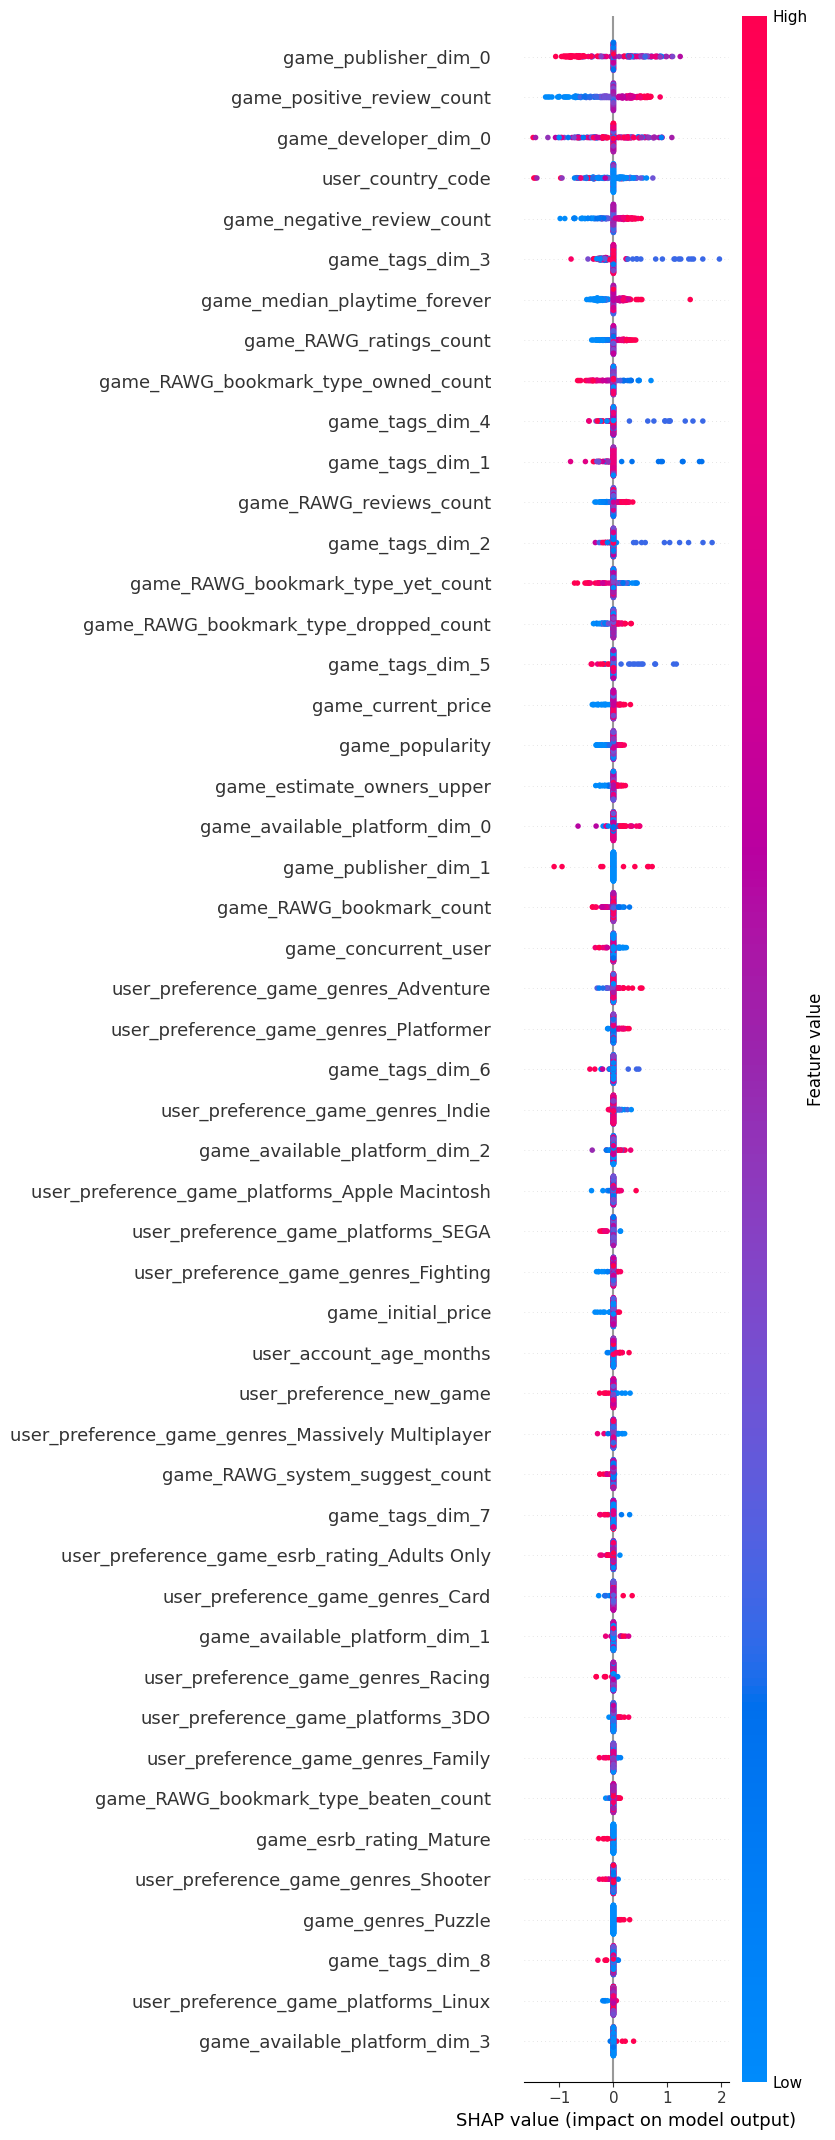

In [27]:
def model_wrapper(input_data):
    with torch.no_grad():
        input_tensor = torch.tensor(input_data).float().to(device)
        output_tensor = best_model(input_tensor)
        return output_tensor.cpu().numpy()

sample_data = [input_batch for input_batch, _, _ in test_loader]
sample_data = torch.cat(sample_data, dim=0)

rng = np.random.default_rng()

# Background and feature batches
background_data = sample_data[rng.choice(sample_data.shape[0], 100, replace=False)].numpy()
feature_data_batch = sample_data[rng.choice(sample_data.shape[0], 200, replace=False)].numpy()

# SHAP explanation
explainer = shap.KernelExplainer(model_wrapper, background_data)
shap_values = explainer.shap_values(feature_data_batch)

shap_values = np.squeeze(np.array(shap_values, dtype=np.float64))
feature_data_batch = feature_data_batch.astype(np.float64)

shap_value_df = pd.DataFrame(shap_values, columns=feature_names)
feature_data_df = pd.DataFrame(feature_data_batch, columns=feature_names)

# Visualize SHAP summary plot
shap.initjs()
shap.summary_plot(
    shap_value_df.values,
    feature_data_df.values,
    feature_names=list(shap_value_df.columns),
    max_display=50
)

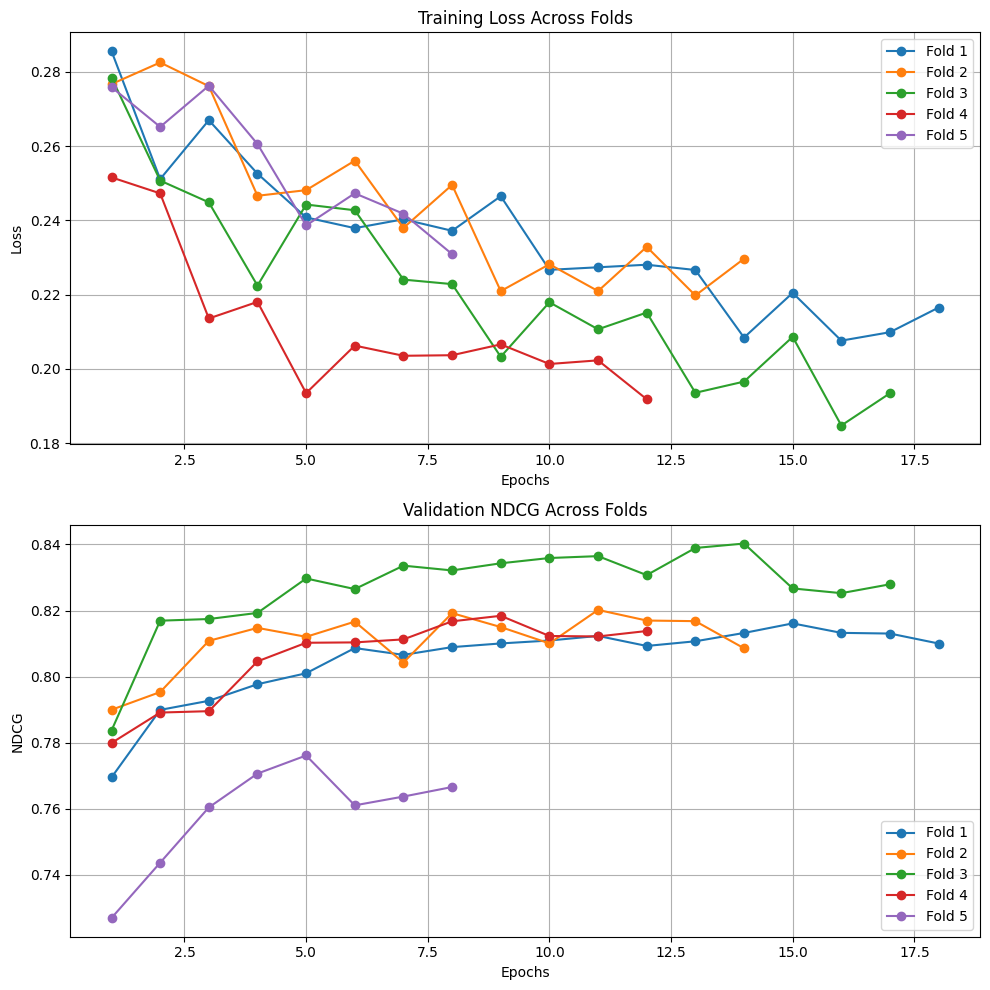

In [28]:
best_training_loss = best_trial.user_attrs['training_loss']
best_validation_loss = best_trial.user_attrs['validation_ndcg']

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Training Loss Plot
for fold_idx, train_loss in enumerate(best_training_loss):
    epochs = range(1, len(train_loss) + 1)
    axes[0].plot(epochs, train_loss, label=f'Fold {fold_idx + 1}', marker='o')

axes[0].set_title('Training Loss Across Folds')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Validation NDCG Plot
for fold_idx, val_ndcg in enumerate(best_validation_loss):
    epochs = range(1, len(val_ndcg) + 1)
    axes[1].plot(epochs, val_ndcg, label=f'Fold {fold_idx + 1}', marker='o')

axes[1].set_title('Validation NDCG Across Folds')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('NDCG')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [29]:
plot_optimization_history(study).show()

In [30]:
plot_param_importances(study).show()

In [31]:
plot_parallel_coordinate(study).show()

In [32]:
plot_slice(study).show()

In [33]:
pip freeze > ..\requirements.txt

Note: you may need to restart the kernel to use updated packages.
